# Time Series Forecasting

## Introduction

We have used QCi’s EmuCore reservoir technology to forecast a time series. What follows is a brief discussion of our approach and some results.

### Device
EmuCore Reservoir Computer

### Reservoir Computing

The idea is to pass data through a randomly initialized neural network and then use the processed data to train a simple linear model downstream, instead of training a full neural netwrok. Reservoir based models are easier to setup and are less expensive to train. Setting up reservoir based models needs less domanin expertise for different applications.

### Recurrent Neural Networks (RNN)

Here we use a Recurrent Neural Networks (RNN) architecture as our reservoir. The reader can refer to Wikipedia and other resources for a detailed explanation of RNNs.

https://en.wikipedia.org/wiki/Recurrent_neural_network

<img src="figures/rnn_model.png" alt="fishy" class="bg-primary mb-1" width="500px">

*Figure 1: A conceptual illustration of an RNN - On the left the model is shown as an input layer x, a hidden layer h, and an output layer y; the input to h is x as well the output of h from previous step. The illustration is unrolled on the right. For example, the input to h(t), hidden later at time t, is the inout xt) at time t as well as the output of hidden layer at time t-1, that is h(t-1). Courtesy of simplilearn.com.*


<img src="figures/reservoir.svg" alt="fishy" class="bg-primary mb-1" width="500px">

*Figure 2: A conventional reservoir computer consisting of input, reservoir, and output layers. The reservoir layer contains a large number of randomly interconnected recurrent, nonlinear nodes.
This architecture is hard wired to accommodate RNN models.*


### QCi's EmuCore

QCI's EmuCore technology is based a time delayed scheme.

<img src="figures/time_delayed_reservoir_schematic.png" alt="fishy" class="bg-primary mb-1" width="500px">

*Figure 3: A time delay based reservoir computer. Similar to a conventional reservoir computer, the architecture includes input, reservoir, and output layers. However, the reservoir layer contain only one physical node that acts as a large set of temporally spaced virtual nodes. The schematic is courtesy of Kumar et al. (2021).*


The reader can refer to the paper by Kumar et. al. (2021) for more details on EmuCore's architecture,

https://arxiv.org/pdf/2102.09049.pdf


## Dataset

Here we use widely used benchmark, namely NARMA10,

$y_{k+1} = 0.3 y_k + 0.05 y_k \sum_{𝑖=0}^{9} y_{k-i} + 1.5 u_k u_{k−9} + 0.1$

where the input 𝑢𝑘 is drawn from a uniform distribution in the interval $[0, 0.5]$.

The function below generates a NARMA10 time series and splits it into training and testing parts.

In [29]:
import numpy as np

def NARMA10(seed, train_size, test_size):
    
    np.random.seed(seed)
    
    total_size = train_size + test_size
    utrain = 0.5 * np.random.rand(total_size, 1)
    ytrain = np.zeros((10, 1))
    
    for i in list(range(9, total_size - 1)):
        temp = (
            0.3 * ytrain[i]
            + 0.05 * ytrain[i] * np.sum(ytrain[i - 10 + 1 : i + 1])
            + 1.5 * utrain[i] * utrain[i - 10 + 1]
            + 0.1
        )
        ytrain = np.append(ytrain, [temp], axis=0)
        
    train_data = {
        "trainInput": utrain[0:train_size],
        "trainTarget": ytrain[0:train_size],
    }
    
    test_data = {
        "testInput": utrain[train_size:total_size],
        "testTarget": ytrain[train_size:total_size],
    }
    
    dataset = {"train_data": train_data, "test_data": test_data}
    
    return dataset

## Training and Testing Data

Let us consider a time series of size 2000 with 1600 samples in the training part and 400. We have

In [30]:
TRAIN_SIZE = 8000
TEST_SIZE = 2000

dataset = NARMA10(seed=0, train_size=TRAIN_SIZE, test_size=TEST_SIZE)

X_train = dataset["train_data"]["trainInput"]
y_train = dataset["train_data"]["trainTarget"].reshape((TRAIN_SIZE))

X_test = dataset["test_data"]["testInput"]
y_test = dataset["test_data"]["testTarget"].reshape((TEST_SIZE))

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(8000, 1)
(2000, 1)
(8000,)
(2000,)


We can plot the signal,

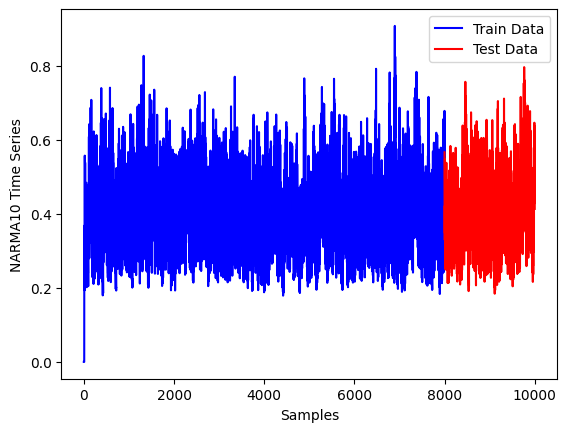

In [31]:
import matplotlib.pyplot as plt

t_train = np.linspace(0, TRAIN_SIZE, TRAIN_SIZE)
t_test = np.linspace(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE, TEST_SIZE)

plt.plot(t_train, y_train, "b")
plt.plot(t_test, y_test, "r")
plt.legend(["Train Data", "Test Data"])
plt.xlabel("Samples")
plt.ylabel("NARMA10 Time Series")
plt.show()

## Push Data through EmuCore

We can now push data through EmuCore using our easy to use interface. 

In [32]:
from emucore_direct.client import EmuCoreClient

IP_ADDR = "172.22.19.49" 
VBIAS = 0.31
GAIN = 0.72
NUM_NODES = 400
NUM_TAPS = 400
FEATURE_SCALING = 0.1
DENSITY = 1.0

# Instantiate an EmuCore instance
client = EmuCoreClient(ip_addr=IP_ADDR)

# A a lock id and reset the device
lock_id, start, end = client.wait_for_lock()
client.reservoir_reset(lock_id=lock_id)

# Configure
client.rc_config(
    lock_id=lock_id,
    vbias=VBIAS,
    gain=GAIN,
    num_nodes=NUM_NODES,
    num_taps=NUM_TAPS
)

# Push data through reservoir
resp_train, train_max_scale_val, train_wgts = client.process_all_data(
    input_data=X_train,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
)

resp_test, test_max_scale_val, test_wgts = client.process_all_data(
    input_data=X_test,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
)

# Release the lock
client.release_lock(lock_id=lock_id)

print(resp_train.shape)
print(resp_test.shape)

(8000, 400)
(2000, 400)


## Build a Linear Model

Once we have the reservoir response, we can build a simple linear regression model using the reservoir response as its input.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression()
lin_model.fit(resp_train, y_train)

y_pred_train = lin_model.predict(resp_train)
y_pred_test = lin_model.predict(resp_test)

# Calculate Mean Squared Error and R-squared
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Train Mean Squared Error: {mse_train:.4f}")
print(f"Train R-squared: {r2_train:.2f}")

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.2f}")

Train Mean Squared Error: 0.0004
Train R-squared: 0.97
Test Mean Squared Error: 0.0004
Test R-squared: 0.97


We can look at the normalized root mean squared error (NRMSE), defined as,

$NRMSE = \sqrt{\frac{1}{m} \sum_{k=0}^{m}\frac{(\hat{y}_k - y_k)^2}{\sigma^2(y)}}$

In [25]:
def NRMSE(target, estimate):
    return np.sqrt(((estimate - target) ** 2).mean()) / np.std(target)

In [26]:
print(NRMSE(y_test, y_pred_test))

0.17932573691607095


## Plot the Results

we can now plot the predicted and target values.

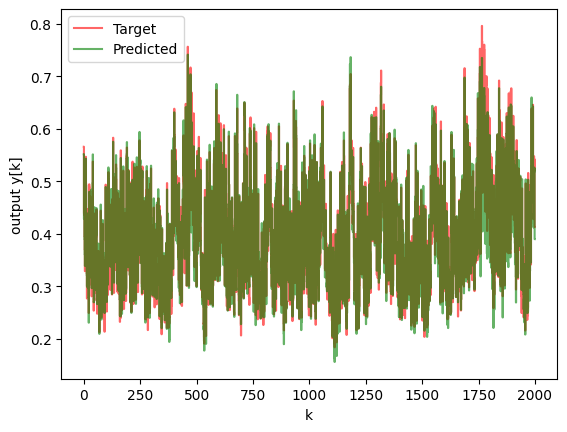

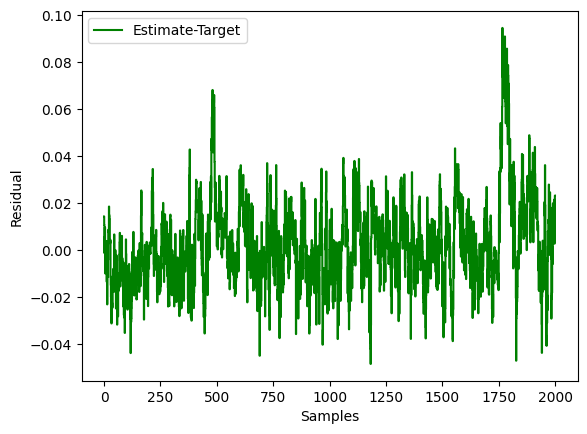

In [27]:
def StepPlotData(y1,y2,legend1="y1",legend2="y2"):
    
    plt.figure()
    assert(y1.shape[0]==y2.shape[0])
    i=np.arange(y1.shape[0])
    plt.step(i,y1,'r', where='mid', label=legend1,alpha=0.6)
    plt.legend()
    plt.step(i,y2,'g', where='mid', label=legend2,alpha=0.6)
    plt.legend()

StepPlotData(y1=y_test, y2=y_pred_test, legend1="Target", legend2="Predicted")
plt.xlabel("k")
plt.ylabel("output y[k]")

plt.figure()
plt.step(y_test-y_pred_test,'g', where='mid', label="Estimate-Target")
plt.legend()

plt.xlabel("Samples")
plt.ylabel("Residual")
plt.show()